In [3]:
# All imports should be in first cell
import cartopy
import GMesh
import imp
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read a target grid

In [4]:
#Read in Mercator grid for 1/8 degree model
Merc_p125_grid =  netCDF4.Dataset('/net2/nnz/grid_generation/workdir/grid_OM4p125_new/tripolar_disp_res8.ncMerc.nc')
Merc_p125_lon = np.array(Merc_p125_grid.variables['x'])
Merc_p125_lat = np.array(Merc_p125_grid.variables['y'])

## Partition the Target grid into non-intersecting blocks
 The 1/8 degree grid is too big to be handled in one go (my 64G machine runs out of memory and starts  to swap rendering the machine useless). Hence, we break the target to pieces and handle them one at a time. 

Future enhancement: 

    Make the block shape arbitrary rather than 2x2
    Delegate these blocks to GPU tasks.

In [10]:
#This works only if the target mesh is "regular"! Niki: Find the mathematical buzzword for "regular"!!
#Is this a regular mesh?
Merc_p125_lon[1,:] - Merc_p125_lon[0,:]

def block_array_1d(a,xb=2):
    a_win = []
    i0 = 0
    lx = a.shape[0]//xb
    for k in range(xb):
        i1=min(a.shape[0],i0+lx)
        a_win.append(a[i0:i1])
        i0=i1
    return a_win

lons=block_array_1d(Merc_p125_lon[0,:],10)
lats=block_array_1d(Merc_p125_lat[:,0],10)


In [6]:
#plt.figure(figsize=(10,10))
#lon = lons[8]
#lat = lats[5]

#lonc = (lon[0]+lon[-1])/2
#latc = (lat[0]+lat[-1])/2
#print("region:", lon[0],lat[0], " to ",lon[-1],lat[-1])

#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
#imp.reload(GMesh)
#target_mesh = GMesh.GMesh( lon=lon, lat=lat )
#print( target_mesh )
#ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lonc, central_latitude=latc))
#ax.set_global()
#ax.stock_img()
#ax.coastlines()
#ax.gridlines()
#target_mesh.plot(ax,subsample=10, transform=cartopy.crs.Geodetic())
#plt.plot(lon[0],  lat[0], 'o', transform=cartopy.crs.PlateCarree())
#plt.plot(lon[-1], lat[-1], 'o', transform=cartopy.crs.PlateCarree())


region: -12.0 30.0775449885  to  23.9375 43.9302532453
<GMesh nj:279 ni:575 shape:(279,575)>


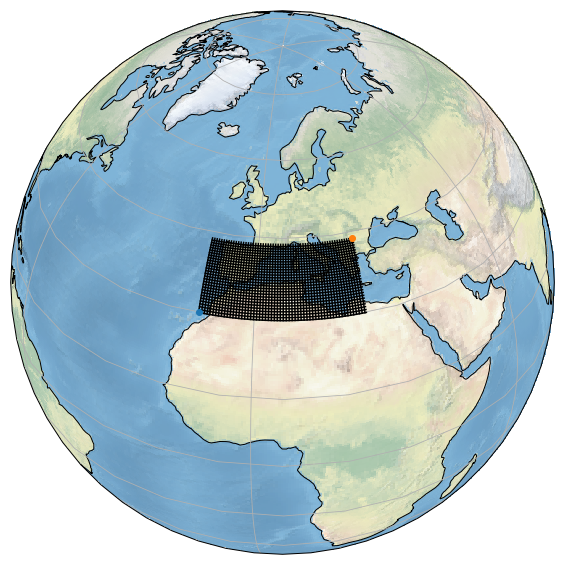

In [11]:
plt.figure(figsize=(10,10))
lon = lons[8]
lat = lats[7]

lonc = (lon[0]+lon[-1])/2
latc = (lat[0]+lat[-1])/2
print("region:", lon[0],lat[0], " to ",lon[-1],lat[-1])

#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
imp.reload(GMesh)
#lon = Merc_p125_lon[0,:]
#lat = Merc_p125_lat[:,0]
target_mesh = GMesh.GMesh( lon=lon, lat=lat )
print( target_mesh )
#ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective())
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lonc, central_latitude=latc))
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()
target_mesh.plot(ax,subsample=10, transform=cartopy.crs.Geodetic())
plt.plot(lon[0],  lat[0], 'o', transform=cartopy.crs.PlateCarree())
plt.plot(lon[-1], lat[-1], 'o', transform=cartopy.crs.PlateCarree())


# Open and read a topographic dataset

Open a topography dataset, check that the topography is on a uniform grid.

In [12]:
# URL of topographic data, names of longitude, latitude and elevation variables
# url,vx,vy,ve = '/archive/gold/datasets/topography/GEBCO_08_v1.nc','longitude','latitude','depth'
url,vx,vy,ve = '/net2/nnz/thin-wall-topography/python/workdir/GEBCO_2014_2D.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO1/.z_bedrock/dods','lon','lat','z_bedrock'
topo_data = netCDF4.Dataset(url)

# Read coordinates of topography
topo_lon = np.array( topo_data.variables[vx][:] )
topo_lat = np.array( topo_data.variables[vy][:] )
print('topography grid array shapes: ' , topo_lon.shape,topo_lat.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())

print('Is mesh uniform?', GMesh.is_mesh_uniform( topo_lon, topo_lat ) )

# Indices in topographic data
ti,tj = target_mesh.find_nn_uniform_source( topo_lon, topo_lat )
#Take all the source point, do not sample!
tis,tjs = slice(ti.min(), ti.max()+1,1), slice(tj.min(), tj.max()+1,1)
print('Slices:', tis, tjs )

# Read elevation data
topo_elv = topo_data.variables[ve][tjs,tis]
# Extract appropriate coordinates
topo_lon = topo_lon[tis]
topo_lat = topo_lat[tjs]

print('Topo shape:', topo_elv.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())

topography grid array shapes:  (43200,) (21600,)
topography longitude range: -179.995833333 179.995833333
topography latitude range: -89.9958333333 89.9958333333
Is mesh uniform? True
Slices: slice(20160, 24473, 1) slice(14409, 16072, 1)
Topo shape: (1663, 4313)
topography longitude range: -11.9958333333 23.9375
topography latitude range: 30.0791666667 43.9291666667


Create a mesh for the purpose of precise plotting of topography

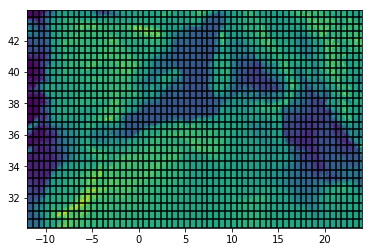

In [13]:
topo_mesh = GMesh.GMesh( lon=topo_lon, lat=topo_lat, from_cell_center=True)
ax = plt.subplot(111)#, projection=cartopy.crs.NearsidePerspective(central_longitude=1.5, central_latitude=51))
topo_mesh.pcolormesh( ax, topo_elv)#, transform=cartopy.crs.PlateCarree() )
target_mesh.plot(ax,subsample=10)#, transform=cartopy.crs.PlateCarree())

Flag topography cells that are sampled by mesh nodes

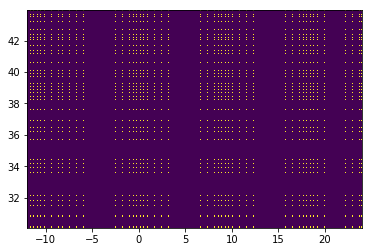

In [14]:
hits = target_mesh.source_hits( topo_lon, topo_lat )

ax = plt.subplot(111) #, projection=cartopy.crs.NearsidePerspective(central_longitude=lonc, central_latitude=latc))
im = topo_mesh.pcolormesh( ax, hits)#, transform=cartopy.crs.PlateCarree() )
#plt.colorbar(im, ax=ax)
#target_mesh.plot(ax, linecolor='w', transform=cartopy.crs.Geodetic())

Refine grid by 2 and re-calculate flagged cells

In [16]:
print(target_mesh)
refine_level_1 = target_mesh.refineby2()
print( refine_level_1 )
hits = refine_level_1.source_hits( topo_lon, topo_lat )

ax = plt.subplot(111)#, projection=cartopy.crs.NearsidePerspective(central_longitude=1.5, central_latitude=51))
im = topo_mesh.pcolormesh( ax, hits)#, transform=cartopy.crs.PlateCarree() )
#plt.colorbar(im, ax=ax)
#refine_level_1.plot(ax, linecolor='w', transform=cartopy.crs.Geodetic())

<GMesh nj:279 ni:575 shape:(279,575)>
<GMesh nj:558 ni:1150 shape:(558,1150)>


AssertionError: Out of bounds i index calculated! i=43199.0

Further refine by 2 and re-calculate flagged cells

<GMesh nj:36 ni:40 shape:(36,40)>


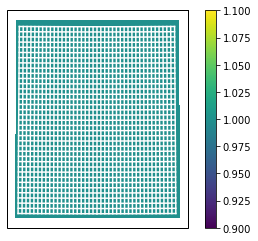

In [7]:
refine_level_2 = refine_level_1.refineby2()
print( refine_level_2 )
hits = refine_level_2.source_hits( topo_lon, topo_lat )

ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=1.5, central_latitude=51))
im = topo_mesh.pcolormesh( ax, hits, transform=cartopy.crs.PlateCarree() )
plt.colorbar(im, ax=ax)
refine_level_2.plot(ax, linecolor='w', transform=cartopy.crs.PlateCarree())

In [8]:
target_mesh.refine_loop( topo_lon, topo_lat );

<GMesh nj:9 ni:10 shape:(9,10)> Hit 110 out of 475 cells (0.0014 Mb)
<GMesh nj:18 ni:20 shape:(18,20)> Hit 399 out of 475 cells (0.0055 Mb)
<GMesh nj:36 ni:40 shape:(36,40)> Hit 475 out of 475 cells (0.0220 Mb)


# Test for source grid with converging Meridians and analog of polar cap

In [9]:
# Mesh across North Pole
target_mesh = GMesh.GMesh( lon=np.linspace(-.5, .5, 3), lat=np.linspace(-.5, .5, 3) )
target_mesh.rotate(y_rot=-90)
print( target_mesh.lat.max() )

# Reload topography
topo_lon = np.array( topo_data.variables[vx][:] )
topo_lat = np.array( topo_data.variables[vy][:] )
print('topography grid array shapes: ' , topo_lon.shape,topo_lat.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())
# Indices in topographic data
ti,tj = target_mesh.find_nn_uniform_source( topo_lon, topo_lat )
tis,tjs = slice(ti.min(), ti.max()+1,1), slice(tj.min(), tj.max()+1,1)
tis=slice(0,43200,5)
print('Slices:', tis, tjs )
# Read elevation data
topo_elv = topo_data.variables[ve][tjs,tis]
# Extract appropriate coordinates
topo_lon = topo_lon[tis]
topo_lat = topo_lat[tjs]

print('Topo shape:', topo_elv.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())

90.0
topography grid array shapes:  (43200,) (21600,)
topography longitude range: -179.99583333333334 179.99583333332703
topography latitude range: -89.99583333333332 89.99583333333334
Slices: slice(0, 43200, 5) slice(21515, 21600, 1)
Topo shape: (85, 8640)
topography longitude range: -179.99583333333334 179.9625
topography latitude range: 89.29583333333333 89.99583333333334


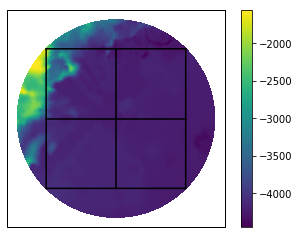

In [10]:
ax = plt.subplot(111, projection=cartopy.crs.NorthPolarStereo())
topomesh = GMesh.GMesh(lon=topo_lon, lat=topo_lat, from_cell_center=True)
im = topomesh.pcolormesh(ax, topo_elv, transform=cartopy.crs.PlateCarree())
plt.colorbar(im,ax=ax)

target_mesh.plot(ax, transform=cartopy.crs.Geodetic())

In [11]:
R = target_mesh.refine_loop( topo_lon, topo_lat )

<GMesh nj:2 ni:2 shape:(2,2)> Hit 259208 out of 734400 cells (0.0001 Mb)
<GMesh nj:4 ni:4 shape:(4,4)> Hit 259224 out of 734400 cells (0.0002 Mb)
<GMesh nj:8 ni:8 shape:(8,8)> Hit 259272 out of 734400 cells (0.0010 Mb)
<GMesh nj:16 ni:16 shape:(16,16)> Hit 259444 out of 734400 cells (0.0039 Mb)
<GMesh nj:32 ni:32 shape:(32,32)> Hit 260096 out of 734400 cells (0.0156 Mb)
<GMesh nj:64 ni:64 shape:(64,64)> Hit 262632 out of 734400 cells (0.0625 Mb)
<GMesh nj:128 ni:128 shape:(128,128)> Hit 272624 out of 734400 cells (0.2500 Mb)
<GMesh nj:256 ni:256 shape:(256,256)> Hit 310266 out of 734400 cells (1.0000 Mb)
<GMesh nj:512 ni:512 shape:(512,512)> Hit 427963 out of 734400 cells (4.0000 Mb)
<GMesh nj:1024 ni:1024 shape:(1024,1024)> Hit 560363 out of 734400 cells (16.0000 Mb)
<GMesh nj:2048 ni:2048 shape:(2048,2048)> Hit 583562 out of 734400 cells (64.0000 Mb)
<GMesh nj:4096 ni:4096 shape:(4096,4096)> Hit 586498 out of 734400 cells (256.0000 Mb)
<GMesh nj:8192 ni:8192 shape:(8192,8192)> Hit 58

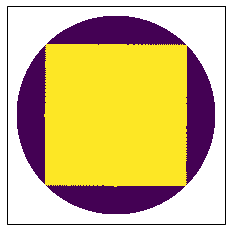

In [12]:
ax = plt.subplot(111, projection=cartopy.crs.NorthPolarStereo())
hits = R[-1].source_hits( topo_lon, topo_lat )
topomesh.pcolormesh(ax, hits, transform=cartopy.crs.PlateCarree());